# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/pk/Softwares/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [7]:
# def sigmoid(x):
#     """
#     A numerically stable version of the logistic sigmoid function.
#     """
#     pos_mask = (x >= 0)
#     neg_mask = (x < 0)
#     z = np.zeros_like(x)
#     z[pos_mask] = np.exp(-x[pos_mask])
#     z[neg_mask] = np.exp(x[neg_mask])
#     top = np.ones_like(x)
#     top[neg_mask] = z[neg_mask]
#     return top / (1 + z)

# def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
#     """
#     Forward pass for a single timestep of an LSTM.

#     The input data has dimension D, the hidden state has dimension H, and we use
#     a minibatch size of N.

#     Note that a sigmoid() function has already been provided for you in this file.

#     Inputs:
#     - x: Input data, of shape (N, D)
#     - prev_h: Previous hidden state, of shape (N, H)
#     - prev_c: previous cell state, of shape (N, H)
#     - Wx: Input-to-hidden weights, of shape (D, 4H)
#     - Wh: Hidden-to-hidden weights, of shape (H, 4H)
#     - b: Biases, of shape (4H,)

#     Returns a tuple of:
#     - next_h: Next hidden state, of shape (N, H)
#     - next_c: Next cell state, of shape (N, H)
#     - cache: Tuple of values needed for backward pass.
#     """
#     next_h, next_c, cache = None, None, None
#     #############################################################################
#     # TODO: Implement the forward pass for a single timestep of an LSTM.        #
#     # You may want to use the numerically stable sigmoid implementation above.  #
#     #############################################################################
#     N, H = prev_h.shape
#     h_x = x.dot(Wx)
#     h_h = prev_h.dot(Wh)
#     big_h = h_x + h_h + b
#     i = sigmoid(big_h[:,:H])
#     f = sigmoid(big_h[:,H:2*H])
#     o = sigmoid(big_h[:,2*H:3*H])
#     g = np.tanh(big_h[:,3*H:])
#     next_c = f * prev_c + i * g
#     tanh_next_c = np.tanh(next_c)
#     next_h = o * np.tanh(next_c)
#     cache = (x, next_h, next_c, prev_h, Wx, Wh, b, i, f, o, g, prev_c, tanh_next_c)
#     ##############################################################################
#     #                               END OF YOUR CODE                             #
#     ##############################################################################

#     return next_h, next_c, cache

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [10]:
# def lstm_step_backward(dnext_h, dnext_c, cache):
#     """
#     Backward pass for a single timestep of an LSTM.

#     Inputs:
#     - dnext_h: Gradients of next hidden state, of shape (N, H)
#     - dnext_c: Gradients of next cell state, of shape (N, H)
#     - cache: Values from the forward pass

#     Returns a tuple of:
#     - dx: Gradient of input data, of shape (N, D)
#     - dprev_h: Gradient of previous hidden state, of shape (N, H)
#     - dprev_c: Gradient of previous cell state, of shape (N, H)
#     - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
#     - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
#     - db: Gradient of biases, of shape (4H,)
#     """
#     dx, dprev_h, dprev_c, dWx, dWh, db = None, None, None, None, None, None
#     #############################################################################
#     # TODO: Implement the backward pass for a single timestep of an LSTM.       #
#     #                                                                           #
#     # HINT: For sigmoid and tanh you can compute local derivatives in terms of  #
#     # the output value from the nonlinearity.                                   #
#     #############################################################################
#     x, next_h, next_c, prev_h, Wx, Wh, b, i, f, o, g, prev_c, tanh_next_c = cache
#     dtanh_next_c = dnext_h * o
#     do = dnext_h * tanh_next_c
#     dnext_c += dtanh_next_c * (1 - (tanh_next_c ** 2))
#     dig = dnext_c
#     dcf = dnext_c
#     di = dig * g
#     dg = dig * i
#     df = dcf * prev_c
#     dprev_c = dcf * f
    
#     dh_big = np.concatenate((di * i * (1 - i), df * f * (1 - f), do * o * (1 - o), dg * (1 - (g ** 2))), axis=1)
#     dh_h = dh_big
#     dh_x = dh_big
#     db = dh_big.sum(0)
#     dWx = x.T.dot(dh_x)
#     dWh = prev_h.T.dot(dh_h)
#     dx = dh_x.dot(Wx.T)
#     dprev_h = dh_h.dot(Wh.T)
#     ##############################################################################
#     #                               END OF YOUR CODE                             #
#     ##############################################################################

#     return dx, dprev_h, dprev_c, dWx, dWh, db


In [4]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.335032254429549e-10
dh error:  3.3963774090592634e-10
dc error:  1.5221723979041107e-10
dWx error:  2.1010960934639614e-09
dWh error:  9.712296109943072e-08
db error:  2.491522041931035e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [12]:
# def lstm_forward(x, h0, Wx, Wh, b):
#     """
#     Forward pass for an LSTM over an entire sequence of data. We assume an input
#     sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
#     size of H, and we work over a minibatch containing N sequences. After running
#     the LSTM forward, we return the hidden states for all timesteps.

#     Note that the initial cell state is passed as input, but the initial cell
#     state is set to zero. Also note that the cell state is not returned; it is
#     an internal variable to the LSTM and is not accessed from outside.

#     Inputs:
#     - x: Input data of shape (N, T, D)
#     - h0: Initial hidden state of shape (N, H)
#     - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
#     - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
#     - b: Biases of shape (4H,)

#     Returns a tuple of:
#     - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
#     - cache: Values needed for the backward pass.
#     """
#     h, cache = None, None
#     #############################################################################
#     # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
#     # You should use the lstm_step_forward function that you just defined.      #
#     #############################################################################
#     N, T, D = x.shape
#     H = h0.shape[1]
#     h = np.zeros((N,T,H))
#     cache = {}
#     prev_h = h0
#     prev_c = np.zeros_like(h0)
#     for t in range(T):
#         h[:,t,:], next_c, cache[t] = lstm_step_forward(x[:,t,:], prev_h, prev_c, Wx, Wh, b)
#         prev_h = np.copy(h[:,t,:])
#         prev_c = next_c
#     cache['input'] = x
#     cache['init_h'] = h0
#     cache['Wx'] = Wx
#     cache['Wh'] = Wh
#     cache['b'] = b
#     ##############################################################################
#     #                               END OF YOUR CODE                             #
#     ##############################################################################

#     return h, cache

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [14]:
# def lstm_backward(dh, cache):
#     """
#     Backward pass for an LSTM over an entire sequence of data.]

#     Inputs:
#     - dh: Upstream gradients of hidden states, of shape (N, T, H)
#     - cache: Values from the forward pass

#     Returns a tuple of:
#     - dx: Gradient of input data of shape (N, T, D)
#     - dh0: Gradient of initial hidden state of shape (N, H)
#     - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
#     - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
#     - db: Gradient of biases, of shape (4H,)
#     """
#     dx, dh0, dWx, dWh, db = None, None, None, None, None
#     #############################################################################
#     # TODO: Implement the backward pass for an LSTM over an entire timeseries.  #
#     # You should use the lstm_step_backward function that you just defined.     #
#     #############################################################################
#     x = cache['input']
#     h0 = cache['init_h']
#     Wx = cache['Wx']
#     Wh = cache['Wh']
#     b = cache['b']
#     N, T, H = x.shape
#     H = h0.shape[1]
#     dh_ts = 0
#     dx = np.zeros_like(x)
#     dWx = np.zeros_like(Wx)
#     dWh = np.zeros_like(Wh)
#     dh0 = np.zeros_like(h0)
#     db = np.zeros_like(b)
#     dnext_c = np.zeros_like(h0)
#     for t in range(T-1, -1, -1):
#         dx[:,t,:], dprev_h_temp, dprev_c_temp, dWx_temp, dWh_temp, db_temp = lstm_step_backward(dh[:,t,:] + dh_ts, dnext_c, cache[t])
#         dWx += dWx_temp
#         dWh += dWh_temp
#         db += db_temp
#         dh_ts = dprev_h_temp
#         dnext_c = dprev_c_temp
#     dh0 = dh_ts
#     ##############################################################################
#     #                               END OF YOUR CODE                             #
#     ##############################################################################

#     return dx, dh0, dWx, dWh, db

In [6]:
#from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.838503094280515e-09
dh0 error:  2.469092580080717e-08
dWx error:  4.748336603829709e-09
dWh error:  1.0424408314821048e-06
db error:  1.9152724138992987e-09


# INLINE QUESTION

Recall that in an LSTM the input gate $i$, forget gate $f$, and output gate $o$ are all outputs of a sigmoid function. Why don't we use the ReLU activation function instead of sigmoid to compute these values? Explain.

# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [7]:
# from builtins import range
# from builtins import object
# import numpy as np

# from cs231n.layers import *
# from cs231n.rnn_layers import *


# class CaptioningRNN(object):
#     """
#     A CaptioningRNN produces captions from image features using a recurrent
#     neural network.

#     The RNN receives input vectors of size D, has a vocab size of V, works on
#     sequences of length T, has an RNN hidden dimension of H, uses word vectors
#     of dimension W, and operates on minibatches of size N.

#     Note that we don't use any regularization for the CaptioningRNN.
#     """

#     def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
#                  hidden_dim=128, cell_type='rnn', dtype=np.float32):
#         """
#         Construct a new CaptioningRNN instance.

#         Inputs:
#         - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
#           and maps each string to a unique integer in the range [0, V).
#         - input_dim: Dimension D of input image feature vectors.
#         - wordvec_dim: Dimension W of word vectors.
#         - hidden_dim: Dimension H for the hidden state of the RNN.
#         - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
#         - dtype: numpy datatype to use; use float32 for training and float64 for
#           numeric gradient checking.
#         """
#         if cell_type not in {'rnn', 'lstm'}:
#             raise ValueError('Invalid cell_type "%s"' % cell_type)

#         self.cell_type = cell_type
#         self.dtype = dtype
#         self.word_to_idx = word_to_idx
#         self.idx_to_word = {i: w for w, i in word_to_idx.items()}
#         self.params = {}

#         vocab_size = len(word_to_idx)

#         self._null = word_to_idx['<NULL>']
#         self._start = word_to_idx.get('<START>', None)
#         self._end = word_to_idx.get('<END>', None)

#         # Initialize word vectors
#         self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
#         self.params['W_embed'] /= 100

#         # Initialize CNN -> hidden state projection parameters
#         self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
#         self.params['W_proj'] /= np.sqrt(input_dim)
#         self.params['b_proj'] = np.zeros(hidden_dim)

#         # Initialize parameters for the RNN
#         dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
#         self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
#         self.params['Wx'] /= np.sqrt(wordvec_dim)
#         self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
#         self.params['Wh'] /= np.sqrt(hidden_dim)
#         self.params['b'] = np.zeros(dim_mul * hidden_dim)

#         # Initialize output to vocab weights
#         self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
#         self.params['W_vocab'] /= np.sqrt(hidden_dim)
#         self.params['b_vocab'] = np.zeros(vocab_size)

#         # Cast parameters to correct dtype
#         for k, v in self.params.items():
#             self.params[k] = v.astype(self.dtype)


#     def loss(self, features, captions):
#         """
#         Compute training-time loss for the RNN. We input image features and
#         ground-truth captions for those images, and use an RNN (or LSTM) to compute
#         loss and gradients on all parameters.

#         Inputs:
#         - features: Input image features, of shape (N, D)
#         - captions: Ground-truth captions; an integer array of shape (N, T) where
#           each element is in the range 0 <= y[i, t] < V

#         Returns a tuple of:
#         - loss: Scalar loss
#         - grads: Dictionary of gradients parallel to self.params
#         """
#         # Cut captions into two pieces: captions_in has everything but the last word
#         # and will be input to the RNN; captions_out has everything but the first
#         # word and this is what we will expect the RNN to generate. These are offset
#         # by one relative to each other because the RNN should produce word (t+1)
#         # after receiving word t. The first element of captions_in will be the START
#         # token, and the first element of captions_out will be the first word.
#         captions_in = captions[:, :-1]
#         captions_out = captions[:, 1:]

#         # You'll need this
#         mask = (captions_out != self._null)

#         # Weight and bias for the affine transform from image features to initial
#         # hidden state
#         W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

#         # Word embedding matrix
#         W_embed = self.params['W_embed']

#         # Input-to-hidden, hidden-to-hidden, and biases for the RNN
#         Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

#         # Weight and bias for the hidden-to-vocab transformation.
#         W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

#         loss, grads = 0.0, {}
#         ############################################################################
#         # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
#         # In the forward pass you will need to do the following:                   #
#         # (1) Use an affine transformation to compute the initial hidden state     #
#         #     from the image features. This should produce an array of shape (N, H)#
#         # (2) Use a word embedding layer to transform the words in captions_in     #
#         #     from indices to vectors, giving an array of shape (N, T, W).         #
#         # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
#         #     process the sequence of input word vectors and produce hidden state  #
#         #     vectors for all timesteps, producing an array of shape (N, T, H).    #
#         # (4) Use a (temporal) affine transformation to compute scores over the    #
#         #     vocabulary at every timestep using the hidden states, giving an      #
#         #     array of shape (N, T, V).                                            #
#         # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
#         #     the points where the output word is <NULL> using the mask above.     #
#         #                                                                          #
#         # In the backward pass you will need to compute the gradient of the loss   #
#         # with respect to all model parameters. Use the loss and grads variables   #
#         # defined above to store loss and gradients; grads[k] should give the      #
#         # gradients for self.params[k].                                            #
#         #                                                                          #
#         # Note also that you are allowed to make use of functions from layers.py   #
#         # in your implementation, if needed.                                       #
#         ############################################################################
#         #(1)
#         h0, cache_image = affine_forward(features, W_proj, b_proj)
#         #(2)
#         rnn_input, cache_word_embed = word_embedding_forward(captions_in, W_embed)
#         #(3)
#         if self.cell_type == 'rnn':
#             rnn_hidden_out, cache_rnn = rnn_forward(rnn_input, h0, Wx, Wh, b)
#         else :
#             rnn_hidden_out, cache_rnn = lstm_forward(rnn_input, h0, Wx, Wh, b)
#         #(4)
#         rnn_out, cache_out = temporal_affine_forward(rnn_hidden_out, W_vocab, b_vocab)
#         #(5)
#         loss, dout = temporal_softmax_loss(rnn_out, captions_out, mask)
        
        
#         #(4)
#         drnn_out, grads['W_vocab'], grads['b_vocab'] = temporal_affine_backward(dout, cache_out)
#         #(3)
#         if self.cell_type == 'rnn':
#             drnn_input, dh0, grads['Wx'], grads['Wh'], grads['b'] = rnn_backward(drnn_out, cache_rnn)
#         else :
#             drnn_input, dh0, grads['Wx'], grads['Wh'], grads['b'] = lstm_backward(drnn_out, cache_rnn)
            
#         #(2)
#         grads['W_embed'] = word_embedding_backward(drnn_input, cache_word_embed)
        
#         #(1)
#         dfeatures, grads['W_proj'], grads['b_proj'] = affine_backward(dh0, cache_image)
#         ############################################################################
#         #                             END OF YOUR CODE                             #
#         ############################################################################

#         return loss, grads


#     def sample(self, features, max_length=30):
#         """
#         Run a test-time forward pass for the model, sampling captions for input
#         feature vectors.

#         At each timestep, we embed the current word, pass it and the previous hidden
#         state to the RNN to get the next hidden state, use the hidden state to get
#         scores for all vocab words, and choose the word with the highest score as
#         the next word. The initial hidden state is computed by applying an affine
#         transform to the input image features, and the initial word is the <START>
#         token.

#         For LSTMs you will also have to keep track of the cell state; in that case
#         the initial cell state should be zero.

#         Inputs:
#         - features: Array of input image features of shape (N, D).
#         - max_length: Maximum length T of generated captions.

#         Returns:
#         - captions: Array of shape (N, max_length) giving sampled captions,
#           where each element is an integer in the range [0, V). The first element
#           of captions should be the first sampled word, not the <START> token.
#         """
#         N = features.shape[0]
#         captions = self._null * np.ones((N, max_length), dtype=np.int32)

#         # Unpack parameters
#         W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
#         W_embed = self.params['W_embed']
#         Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
#         W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

#         ###########################################################################
#         # TODO: Implement test-time sampling for the model. You will need to      #
#         # initialize the hidden state of the RNN by applying the learned affine   #
#         # transform to the input image features. The first word that you feed to  #
#         # the RNN should be the <START> token; its value is stored in the         #
#         # variable self._start. At each timestep you will need to do to:          #
#         # (1) Embed the previous word using the learned word embeddings           #
#         # (2) Make an RNN step using the previous hidden state and the embedded   #
#         #     current word to get the next hidden state.                          #
#         # (3) Apply the learned affine transformation to the next hidden state to #
#         #     get scores for all words in the vocabulary                          #
#         # (4) Select the word with the highest score as the next word, writing it #
#         #     (the word index) to the appropriate slot in the captions variable   #
#         #                                                                         #
#         # For simplicity, you do not need to stop generating after an <END> token #
#         # is sampled, but you can if you want to.                                 #
#         #                                                                         #
#         # HINT: You will not be able to use the rnn_forward or lstm_forward       #
#         # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
#         # a loop.                                                                 #
#         #                                                                         #
#         # NOTE: we are still working over minibatches in this function. Also if   #
#         # you are using an LSTM, initialize the first cell state to zeros.        #
#         ###########################################################################
#         N, D = features.shape
#         #(1)
#         h0, cache_image = affine_forward(features, W_proj, b_proj)
#         #(2)
#         prev_word = self._start * np.ones((N), dtype=np.int32)
#         prev_h = h0
#         if self.cell_type == 'lstm':
#             prev_c = np.zeros_like(h0)
        
#         for m in range(max_length):
#             rnn_input, _ = word_embedding_forward(prev_word, W_embed)
#             if self.cell_type == 'rnn':
#                 next_h, _ = rnn_step_forward(rnn_input, prev_h, Wx, Wh, b)
#             else:
#                 next_h, next_c, _ = lstm_step_forward(rnn_input, prev_h, prev_c, Wx, Wh, b)
#             next_h = next_h[:,np.newaxis,:]
#             out, _ = temporal_affine_forward(next_h, W_vocab, b_vocab)
#             out = out[:,0,:]
#             captions[:,m] = np.argmax(out, axis=1)
#             prev_word = captions[:,m]
#             prev_h = next_h[:,0,:]
#             prev_c = next_c
#         ############################################################################
#         #                             END OF YOUR CODE                             #
#         ############################################################################
#         return captions


In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

/home/pk/Softwares/Stanford_231n/assignment3/cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829099
(Iteration 21 / 100) loss: 30.062621
(Iteration 31 / 100) loss: 14.020046
(Iteration 41 / 100) loss: 6.004625
(Iteration 51 / 100) loss: 1.851886
(Iteration 61 / 100) loss: 0.638506
(Iteration 71 / 100) loss: 0.283131
(Iteration 81 / 100) loss: 0.237077
(Iteration 91 / 100) loss: 0.124421


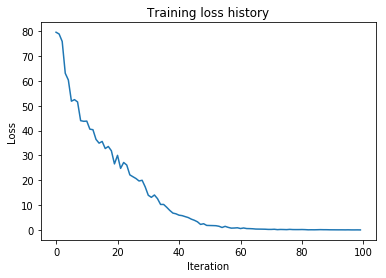

In [9]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()